# Building Your Own Gaussian Process Model

Due Date: March 15th, 2024 | 21:00 on Canvas

## Assignment Prompt

Based off of the Mauna Loa CO2 dataset.

Per the assignment prompt:

"This assignment requires you to fit a Gaussian process model to the Mauna Loa data set. It is a univariate dataset that comprises the monthly average carbon dioxide concentration, measured in parts per million.

You will find the data at this [site](https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html). You will have to download the `monthly_in_situ_co2_mlo.csv` file directly. Details about the data can be found in reference 1.

The plot below shows the data: year vs. CO2 (ppm). Some rows of the table have -99.99 values; these may be ignored. Note that as there are 12 measurements per year (1 for each month), utilizing just the year as the covariate is not appropriate, and that is why the “Date” or third column must be used.

Your training data must be limited to all years before 2014, i.e., you may only use CO2 concentrations in the years 1958 to 2013. It is entirely your decision whether you wish to use all this data, or select a subset."

### Import and Visualize Train and Test Data

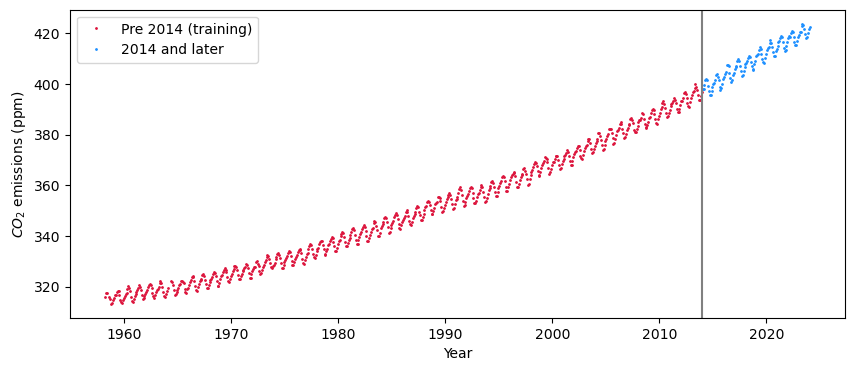

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# read in and clean the data:
df = pd.read_csv('monthly_in_situ_co2_mlo.csv',skiprows=64,header=None)
df.drop([0,1,2,5,6,7,8,9,10],axis=1,inplace=True)
df.columns = ["Date","CO2"]
df = df[df['CO2']> 0]

# visualize training vs test data
df2014 = df[df['Date']< 2014]
dfnew = df[df['Date']>= 2014]

fig = plt.figure(figsize=(10,4))
plt.plot(df2014['Date'].values, df2014['CO2'].values, 'o', ms=1, color='crimson', label='Pre 2014 (training)')
plt.plot(dfnew['Date'].values, dfnew['CO2'].values, 'o', ms=1, color='dodgerblue', label='2014 and later')
plt.legend()
plt.axvline(x=2014, color="grey")
plt.xlabel('Year')
plt.ylabel(r'$CO_2$ emissions (ppm)')
plt.show()

### Grading Criteria

- Appropriate importing of the data and filtering of non-relevant rows. I will run your code on the “.csv” file as provided on the Scripps website. You cannot submit your amended version of the data.
- Use of multiple kernel functions, justifying what exactly each kernel is doing.
- A well-documented Jupyter notebook with equations for all the relevant formulas and code. If your code does not run, or produces an error upon running, you will loose a lot of marks.
- One approach for hyperparameter inference (e.g., maximum likelihood, cross validation, Markov chain Monte Carlo, etc.). Please note that the signal noise need not be optimized over (but can be if you wish).
- You will have to analytically calculate any gradients for hyperparameter inference. To clarify, code that does not use gradients, or code where the gradients are incorrect, will not receive full marks. To check your gradients you can always use finite differences.
- You are restricted to the following libraries: numpy, seaborn, matplotlib, scipy, pandas. Thus, you will have to build a lot of the codebase yourself.
- The last plot in your submission should have the same data as the plot above (both pre- and post-), along with predictive posterior mean and standard deviation contours.

### Grading Rubric

- Data importing [5]
- GP model architecture (i.e. kernels) [5]
- Hyperparameter inference [10]
- Clarity of documentation [5]

## Begin Coding

In the following code, we have borrowed substantial coding infrastructure from the webpage "GP 101" [1].

In [45]:
# allowed libraries: numpy, seaborn, matplotlib, scipy, pandas

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.linalg import cholesky, solve_triangular
import seaborn as sns
sns.set_theme(font_scale=1.0)
sns.set_style("white")
sns.set_style("ticks")
palette = sns.color_palette('deep')

In [46]:
# define the size of the training data set
N = df2014.shape[0]

The three code blocks below define the kernel, a utility function for *tiling*, and the posterior calculation. To clarify, this is the predictive posterior distribution evaluated at some *test* locations, $\mathbf{X}_{\ast}$. The expression for both the predictive posterior mean and covariance are given by:

$$
\begin{aligned}
\mathbb{E} \left[ \mathbf{y}_{\ast} | \mathbf{X}_{\ast} \right] & = \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X} \right) \left[\mathbf{K}\left( \mathbf{X}, \mathbf{X} \right) + \sigma_{n}^2 \mathbf{I} \right]^{-1} \mathbf{y} \\
Covar\left[ \mathbf{y}_{\ast} | \mathbf{X}_{\ast} \right] & = \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X}_{\ast} \right) - \mathbf{K}\left( \mathbf{X}_{\ast}, \mathbf{X} \right) \left[\mathbf{K}\left( \mathbf{X}, \mathbf{X} \right) + \sigma_{n}^2 \mathbf{I} \right]^{-1} \mathbf{K}\left( \mathbf{X}, \mathbf{X}{\ast} \right)
\end{aligned}
$$

In [47]:
def kernel(xa, xb, amp, ll):
    Xa, Xb = get_tiled(xa, xb)
    return amp**2 * np.exp(-0.5 * 1./ll**2 * (Xa - Xb)**2 )

def get_tiled(xa, xb):
    m, n = len(xa), len(xb)
    xa, xb = xa.reshape(m,1) , xb.reshape(n,1)
    Xa = np.tile(xa, (1, n))
    Xb = np.tile(xb.T, (m, 1))
    return Xa, Xb

def get_posterior(amp, ll, x, x_data, y_data, noise):
    u = y_data.shape[0]
    mu_y = np.mean(y_data)
    y = (y_data - mu_y).reshape(u,1)
    Sigma = noise * np.eye(u)
    
    Kxx = kernel(x_data, x_data, amp, ll)
    Kxpx = kernel(x, x_data, amp, ll)
    Kxpxp = kernel(x, x, amp, ll)
    
    # Inverse
    jitter = np.eye(u) * 1e-12
    L = cholesky(Kxx + Sigma + jitter)
    S1 = solve_triangular(L.T, y, lower=True)
    S2 = solve_triangular(L.T, Kxpx.T, lower=True).T
    
    mu = S2 @ S1  + mu_y
    cov = Kxpxp - S2 @ S2.T
    return mu, cov

In [49]:
Xt = dfnew['Date'].values # test data locations (Date)

# Hyperparameters (note these are not optimized!)
length_scale = 7.0
amplitude = 0.8


noise_variance = 0.1
mu, cov = get_posterior(amplitude, length_scale, Xt, df2014['Date'].values, df2014['CO2'].values, noise_variance)

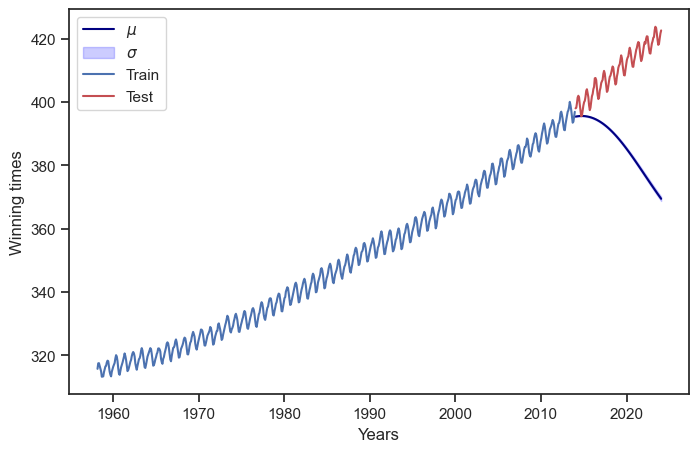

In [54]:
Xt = Xt.flatten()
mu = mu.flatten() 
std = np.sqrt(np.diag(cov)).flatten()

fig = plt.figure(figsize=(8, 5))
plt.plot(Xt, mu, '-', label=r'$\mu$', color='navy')
plt.fill_between(Xt, mu+std, mu-std, color='blue', alpha=0.2, label=r'$\sigma$')
plt.plot(df2014['Date'].values, df2014['CO2'].values, 'b', label='Train', ms=8)
plt.plot(dfnew['Date'].values, dfnew['CO2'].values, 'r', label='Test')
plt.xlabel('Years')
plt.ylabel('Winning times')
plt.legend()
plt.show()